# Create Mistag Rate for ttbar All-Hadronic Analysis

This currently uses a very small NANOAOD skim that requires:
- At least two jets with pt > 350 GeV and |eta| < 2.5
- Anti-tag and probe selection

Creates mistag rates for six categories :
- Central, 0 b-tag
- Central, 1 b-tag
- Central, 2 b-tag
- Forward, 0 b-tag
- Forward, 1 b-tag
- Forward, 2 b-tag

Here, central is |eta| < 1.0 and forward is > 1.0. 

Creates rates separately for 2016, 2017, and 2018 data, they have different pixel detectors and pileup distributions. This manifests in the rates. 



The ttbar from 2017 simulation is subtracted (`TTToHadronic_TuneCP5_13TeV-powheg-pythia8`), in the future we will switch to use 2016,2017,2018 separately. The cross section at 13 TeV is 831.76 pb, and the BR to all-jets (for this MC sample) is 0.457. 

The luminosities are 36.26, 41.37, 14.383 fb$^{-1}$ for the three runs. 

Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficien

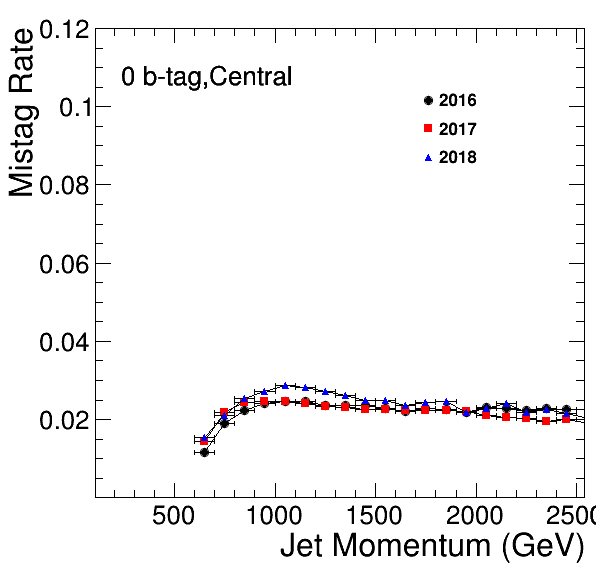

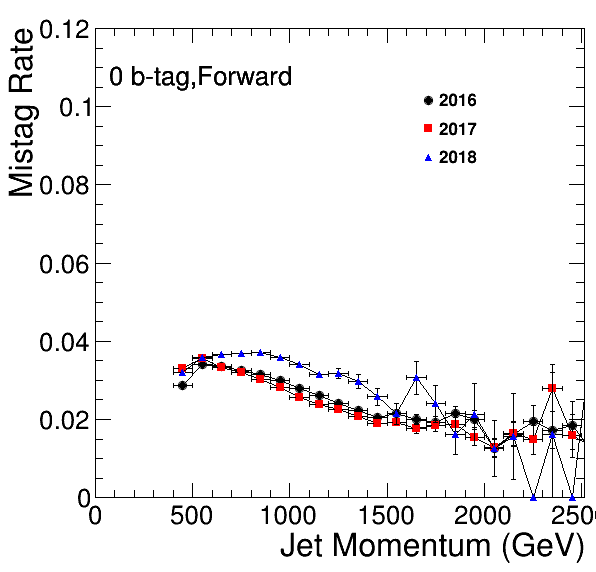

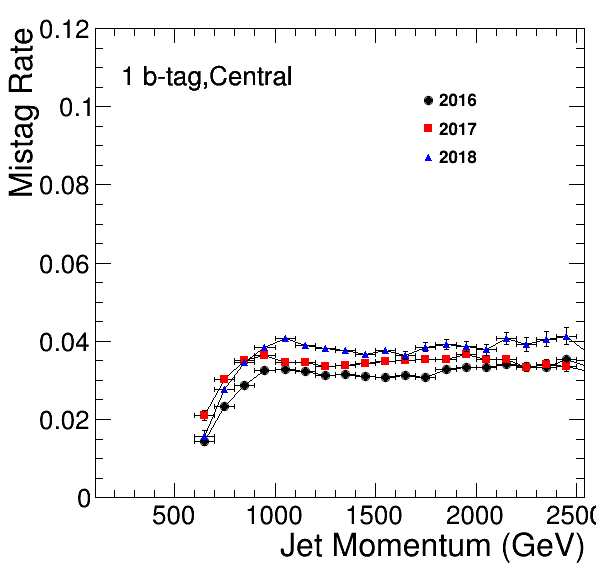

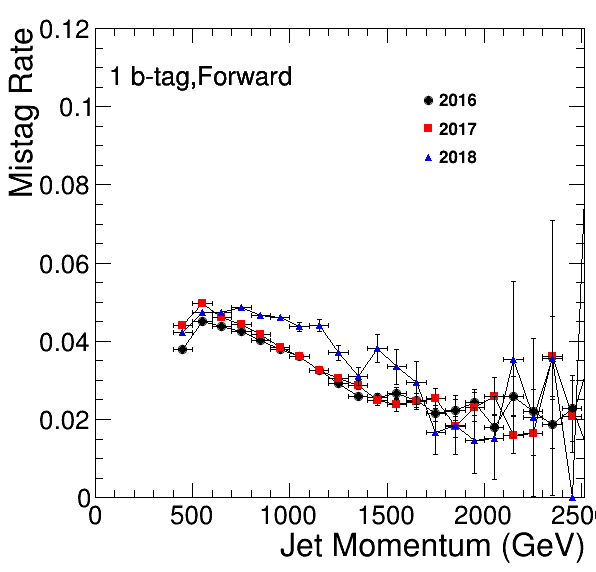

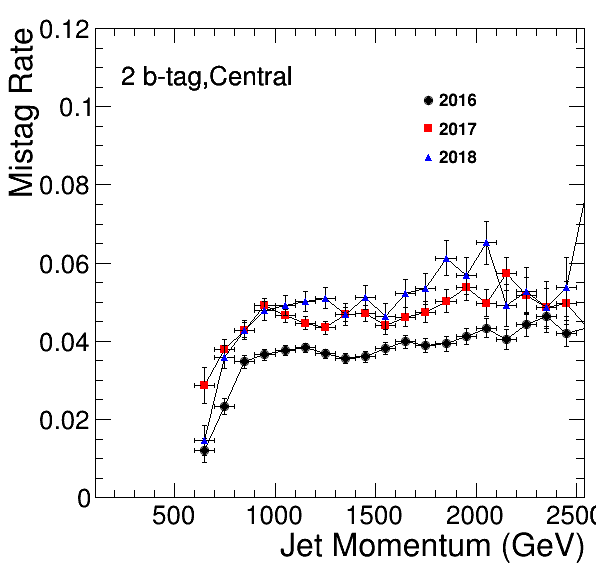

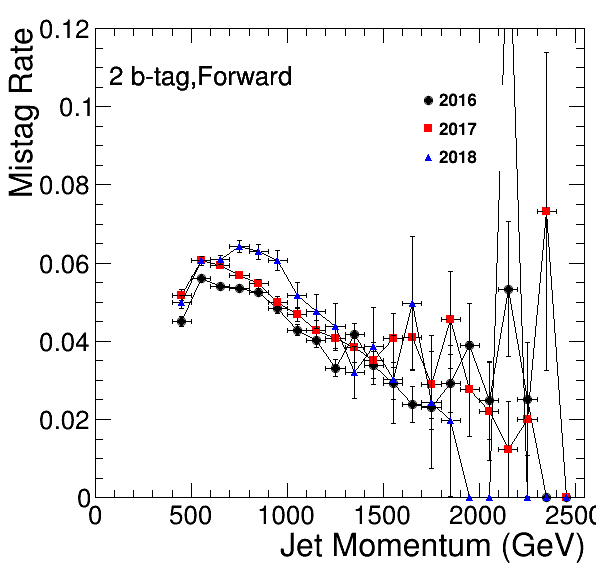

In [5]:
#!/usr/bin/env python

import ROOT
import itertools


from tdrstyle import setTDRStyle


setTDRStyle()

s_2018 = 'mistag_DijetSkim_Nrp_JetHT_Run2018%s-PromptReco_AntiTag.root'
runs_2018 = ['A', 'B']
hists_2018 = []
s_2017 = 'mistag_DijetSkim_Nrp_JetHT_Run2017%s-17Nov2017_AntiTag.root'
runs_2017 = ['B', 'C', 'D', 'E', 'F']
hists_2017 = []
s_2016 = 'mistag_DijetSkim_Nrp_JetHT_Run2016%s-17Nov2017_AntiTag.root'
runs_2016 = ['B', 'C', 'D', 'E', 'F', 'G', 'H']
hists_2016 = []
styles = [20,21,22]
colors = [1,2,4]

f_ttbar = ROOT.TFile( 'mistag_TTToHadronic_TuneCP5_13TeV-powheg-pythia8_AntiTag.root' )

outfile = ROOT.TFile("mistag_rates.root", "RECREATE")

lumis = [36.26, 41.37, 14.383] # fb^-1
ttbar_xs = 0.83176 * 0.457 # fb, with 45.7% BR for all-jets mode

runs_list = [ runs_2016, runs_2017, runs_2018]
basestrs = [ s_2016, s_2017, s_2018 ]

btagcats = ["0 b-tag", "1 b-tag", "2 b-tag"]   # 0, 1, >=2 btags
ycats = [',Central', ',Forward']          # Central and forward
# Combine categories like "0bcen", "0bfwd", etc:
anacats = [ b+y for b,y in itertools.product( btagcats, ycats) ]
ncats = 6
files = []
effs = []
canvs = []
legs = []
mistags = []

latex = ROOT.TLatex()
latex.SetNDC()
latex.SetTextFont(42)
latex.SetTextAlign(31) 
latex.SetTextSize(0.05)   

for icat in xrange(ncats) :
    c1 = ROOT.TCanvas("c" + str(icat), "c" + str(icat))
    leg = ROOT.TLegend(0.7, 0.7, 0.85, 0.85)
    leg.SetFillColor(0)
    leg.SetBorderSize(0)
    for iyear,year in enumerate( ['2016', '2017', '2018'] ):
        dens = []
        nums = []
        for irun,run in enumerate(runs_list[iyear]):
            s = basestrs[iyear] % ( run )
            f = ROOT.TFile( s )
            num = f.Get("ttbarres/preddist%s_num" % (icat) ).Clone('num' + str(icat) + str(run))
            den = f.Get("ttbarres/preddist%s_den" % (icat) ).Clone('den' + str(icat) + str(run))            
            num.Rebin(100)
            den.Rebin(100)
            nums.append(num)
            dens.append(den)            
            files.append(f)
        numtot = nums[0].Clone("numtot" + str(icat))
        dentot = dens[0].Clone("dentot" + str(icat))
        mistagrate = numtot.Clone("mistagrate_" + str(icat) + "_" + year)
        numtot.Sumw2()
        dentot.Sumw2()
        mistagrate.Divide( numtot, dentot, 1.,1., 'b')
        for hist in nums[1:]:
            numtot.Add( hist )
        for hist in dens[1:]:
            dentot.Add(hist)
        ttbar_num = f_ttbar.Get("ttbarres/preddist%s_num" % (icat) ).Clone('num_ttbar' + str(icat) + str(run))
        ttbar_den = f_ttbar.Get("ttbarres/preddist%s_den" % (icat) ).Clone('den_ttbar' + str(icat) + str(run))
        ttbar_num.Sumw2()
        ttbar_den.Sumw2()
        ttbar_num.Scale( ttbar_xs * lumis[iyear] / ttbar_num.Integral() )
        ttbar_den.Scale( ttbar_xs * lumis[iyear] / ttbar_den.Integral() )
        ttbar_num.Rebin(100)
        ttbar_den.Rebin(100)
        numtot.Add( ttbar_num, -1.0 )
        dentot.Add( ttbar_den, -1.0 )
        efftot = ROOT.TEfficiency(numtot,dentot)
        efftot.SetName('efftot' + str(icat) + str(iyear))            
        efftot.SetTitle( anacats[icat] + ';Jet Momentum (GeV);Mistag Rate')   
        latex.DrawLatex(0.5, 0.85, anacats[icat])
        efftot.SetMarkerStyle( styles[iyear] )
        efftot.SetMarkerColor( colors[iyear] )
        tex = ROOT.TLatex()
        leg.AddEntry( efftot, year, 'p')
        if iyear == 0 : 
            efftot.Draw('AL')
            ROOT.gPad.Update()
            efftot.GetPaintedGraph().GetXaxis().SetRangeUser(0,2500)
            efftot.GetPaintedGraph().SetMaximum(0.12)
        else :
            efftot.Draw("L same")
        effs.append(efftot)
        mistags.append(mistagrate)
        

    canvs.append(c1)
    leg.Draw()
    legs.append(leg)
    c1.Update()
    c1.Print('mistags_%d.png' % (icat), 'png')
    c1.Print('mistags_%d.pdf' % (icat), 'pdf')
    c1.Draw()
    
outfile.cd()
for mistag in mistags:
    mistag.Write()
outfile.Close()


